# PROJECT 1

Name Maeva CHAMBEAU 

## Introduction 




In [1]:
import os
import nltk
import datetime
import re
import sys
import datetime

from os import walk
from bs4 import BeautifulSoup
from datetime import datetime
import requests
import pandas as pd

from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import word_tokenize, pos_tag


from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import model_selection, naive_bayes
from sklearn.metrics import accuracy_score

## Creation of the dataframe 

In [3]:
path = 'presidents-speeches/'

list_ = []
                        
def general_extract_datas():
    for (root, dirs, files) in walk(path):
        if len(dirs) == 1:
            path2 = root + '/'
            for (root2, dirs2, files2) in walk(path2):
                speech = []
                extract_president_speech_date(files2, root, root2)
                    
def extract_president_speech_date(files2, root, root2): 
    for i in range(0,len(files2)):
                    dic = {}
                    if files2[i] != 'initial.txt':
                        president_name = root.split("/")[1]
                        dic['president name'] = president_name
                        file_path = "{}/{}".format(root2,files2[i])
                        date1 = files2[i].replace('__', ' ')
                        date2 = date1.rsplit(' ', 1)[0]
                        dic['date'] = datetime.strptime(date2, "%B %d, %Y").strftime("%Y/%m/%d")
                        with open(file_path) as file:
                            data = file.readlines()[0].lower().replace('\\n','').lstrip('b')
                            dic['speech'] = data
                            list_.append(dic)
                    
general_extract_datas()

In [4]:
data=pd.DataFrame(list_)
data

,president name,date,speech
0,Andrew Jackson,1834/04/15,'to the senate of the united states:it appears...
1,Andrew Jackson,1834/04/21,'to the senate of the united states:having rea...
2,Andrew Jackson,1834/12/01,'fellow citizens of the senate and house of re...
3,Andrew Jackson,1832/12/10,"'by andrew jackson, president of the united st..."
4,Andrew Jackson,1833/12/12,'i have attentively considered the resolution ...
...,...,...,...
371,Thomas Jefferson,1802/11/03,"""to brother handsome lake: i have re..."
372,Thomas Jefferson,1804/11/08,'to the senate and house of representatives of...
373,Thomas Jefferson,1808/11/08,""" to the senate and house of representatives ..."
374,Thomas Jefferson,1803/10/17,'to the senate and house of representatives of...


In [5]:
from pandas.api.types import CategoricalDtype
order = CategoricalDtype(['George Washington', 'Thomas Jefferson', 'Andrew Jackson', 'Franklin D. Roosevelt', 'Richard M. Nixon', 'Ronald Reagan', 'George H. W. Bush', 'Bill Clinton', 'George W. Bush','Barack Obama', 'Donald Trump'], ordered=True)
data['president name'] = data['president name'].astype(order)
data.sort_values(by = ['president name', 'date'], inplace = True)
data = data.reset_index(drop=True)


## Preprocessing part 

In [6]:
# Tokenisation 
data['speech'].dropna(inplace=True)
data['word tokenize'] = data['speech'].apply(word_tokenize)
data['sent tokenize'] = data['speech'].apply(sent_tokenize)


In [7]:
data['word sent tokenize'] = data['sent tokenize']

# creer une liste de mots contenant les noms du discour 
for i in data.index:
    word = []
    for sentence in data['sent tokenize'][i]:
        word.append(word_tokenize(sentence))
        data['word sent tokenize'][i] = word
        
# remove punctuations with lowercasing
# create a word list with words totally in lower case
for i in data.index:
    words = []
    for word in data['word tokenize'][i]:
        if word.isalpha() == True:
            words.append(word.lower())
            data['word tokenize'][i] = words
                       
# Removing stopwords
# create a list of important words for each speech = remove stopwords           
for i in data.index:
    words = []
    for word in data['word tokenize'][i]:
        if not word in stopwords.words('english'):
            words.append(word)
            data['word tokenize'][i] = words 
    

<ipython-input-7-af691fb20007>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['word sent tokenize'][i] = word
<ipython-input-7-af691fb20007>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['word tokenize'][i] = words
<ipython-input-7-af691fb20007>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['word tokenize'][i] = words


In [8]:

# Lemmatizer
from collections import defaultdict
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import numpy as np

tag_map = defaultdict(lambda: wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

stopWords = stopwords.words('english')
word_lemmatizer = WordNetLemmatizer()

for index, entry in enumerate(data['word tokenize']):
    words = []
    for word, tag in pos_tag(entry):
        if word not in stopWords:
            words.append(word_lemmatizer.lemmatize(word,tag_map[tag[0]]))
        data.loc[index, 'processed'] = ' '.join(words)

In [9]:
data

,president name,date,speech,word tokenize,sent tokenize,word sent tokenize,processed
0,George Washington,1789/04/30,'fellow citizens of the senate and the house o...,"[citizens, senate, house, representatives, amo...",['fellow citizens of the senate and the house ...,"[['fellow, citizens, of, the, senate, and, the...",citizen senate house representative among vici...
1,George Washington,1789/10/03,'whereas it is the duty of all nations to ackn...,"[duty, nations, acknowledge, providence, almig...",['whereas it is the duty of all nations to ack...,"[['whereas, it, is, the, duty, of, all, nation...",duty nation acknowledge providence almighty go...
2,George Washington,1790/01/08,'fellow citizens of the senate and house of re...,"[citizens, senate, house, representatives, emb...",['fellow citizens of the senate and house of r...,"[['fellow, citizens, of, the, senate, and, hou...",citizen senate house representative embrace gr...
3,George Washington,1790/12/08,' fellow citizens of the senate and house of r...,"[fellow, citizens, senate, house, representati...",[' fellow citizens of the senate and house of ...,"[[', fellow, citizens, of, the, senate, and, h...",fellow citizen senate house representative mee...
4,George Washington,1790/12/29,"' i the president of the united states, by my ...","[president, united, states, mouth, written, sp...","[' i the president of the united states, by my...","[[', i, the, president, of, the, united, state...",president united state mouth write speech sign...
...,...,...,...,...,...,...,...
371,Donald Trump,2019/09/24,'president trump:\xc2\xa0 thank you very much....,"[trump, thank, president, distinguished, deleg...",['president trump:\xc2\xa0 thank you very much...,"[['president, trump, :, \xc2\xa0, thank, you, ...",trump thank president distinguish delegate amb...
372,Donald Trump,2019/09/25,'president trump:\xc2\xa0 thank you very much....,"[trump, thank, thank, well, thank, tremendous,...",['president trump:\xc2\xa0 thank you very much...,"[['president, trump, :, \xc2\xa0, thank, you, ...",trump thank thank well thank tremendous three ...
373,Donald Trump,2019/10/27,"'last night, the united states brought the wor...","[night, united, states, brought, number, one, ...","['last night, the united states brought the wo...","[['last, night, ,, the, united, states, brough...",night united state bring number one terrorist ...
374,Donald Trump,2020/01/03,"'hello, everybody.\xc2\xa0well, thank you very...","[thank, good, afternoon, president, highest, s...","['hello, everybody.\xc2\xa0well, thank you ver...","[['hello, ,, everybody.\xc2\xa0well, ,, thank,...",thank good afternoon president high solemn dut...


## Part A

In [10]:
train_x, test_x, train_y, test_y = model_selection.train_test_split(data['speech'],data['president name'], test_size = 0.2)

train_x_pr, test_x_pr, train_y_pr, test_y_pr = model_selection.train_test_split(data['processed'],data['president name'], test_size = 0.2)


In [11]:
tfidf_vect = TfidfVectorizer()
tfidf_vect.fit(data['speech'])
train_x_tfidf = tfidf_vect.transform(train_x)
test_x_tfidf = tfidf_vect.transform(test_x)

tfidf_vect_pr = TfidfVectorizer()
tfidf_vect_pr.fit(data['processed'])
train_x_tfidf_pr = tfidf_vect_pr.transform(train_x_pr)
test_x_tfidf_pr = tfidf_vect_pr.transform(test_x_pr)

In [11]:
count_vect = CountVectorizer()
count_vect.fit(data['speech'])
train_x_cv = count_vect.transform(train_x)
test_x_cv = count_vect.transform(test_x)

count_vect_pr = CountVectorizer()
count_vect_pr.fit(data['processed'])
train_x_cv_pr = count_vect_pr.transform(train_x_pr)
test_x_cv_pr = count_vect_pr.transform(test_x_pr)

In [12]:
naive_tfidf = naive_bayes.MultinomialNB()
naive_tfidf.fit(train_x_tfidf, train_y)
predictions_tfidf = naive_tfidf.predict(test_x_tfidf)
print("Naive Bayes accuracy score Tfidf non-processed data: ", accuracy_score(predictions_tfidf, test_y))


naive_tfidf_pr = naive_bayes.MultinomialNB()
naive_tfidf_pr.fit(train_x_tfidf_pr, train_y_pr)
predictions_tfidf_pr = naive_tfidf_pr.predict(test_x_tfidf_pr)
print("Naive Bayes accuracy score Tfidf processed data: ", accuracy_score(predictions_tfidf_pr, test_y_pr))

naive_cv = naive_bayes.MultinomialNB()
naive_cv.fit(train_x_cv, train_y)
predictions_cv = naive_cv.predict(test_x_cv)
print("Naive Bayes accuracy score Count Vectorizer non-processed data: ", accuracy_score(predictions_cv, test_y))


naive_cv_pr = naive_bayes.MultinomialNB()
naive_cv_pr.fit(train_x_cv_pr, train_y_pr)
predictions_cv_pr = naive_cv_pr.predict(test_x_cv_pr)
print("Naive Bayes accuracy score Count Vectorizer processed data: ", accuracy_score(predictions_cv_pr, test_y_pr))

Naive Bayes accuracy score Tfidf non-processed data:  0.2894736842105263
Naive Bayes accuracy score Tfidf processed data:  0.2894736842105263
Naive Bayes accuracy score Count Vectorizer non-processed data:  0.75
Naive Bayes accuracy score Count Vectorizer processed data:  0.8026315789473685


# Part B


In [13]:
# verrification for me 
list_president = list(data['president name'].unique())
list_president

['George Washington',
 'Thomas Jefferson',
 'Andrew Jackson',
 'Franklin D. Roosevelt',
 'Richard M. Nixon',
 'Ronald Reagan',
 'George H. W. Bush',
 'Bill Clinton',
 'George W. Bush',
 'Barack Obama',
 'Donald Trump']

In [47]:

""""def sentiment_analyzer_scores (compteur, comp_, negatif_, positif_):
    for sentence in speech:
        compteur +=1
        score = analyser.polarity_scores (sentence)
        negatif_ = negatif_ + score['neg']
        positif_ = positif_ + score['pos']
        comp_ = comp_ + score['compound']
        return (compteur, comp_, negatif_, positif_)
        
        
    scoresPos = []
    scoresNeg = []
    for sentence in speech:
        
        negatif.append(score['neg'])
        positif.append(score['pos'])
    scoresPos.append(sum(positif)/len(positif))
    scoresNeg.append(sum(negatif)/len(negatif))  
    return (scoresPos,scoresNeg)"""
    


In [62]:
analyser = SentimentIntensityAnalyzer()


# algo for all of president speech create a dataframe  ['score positif '] 
# and dataframe ['score negative ']
data['scores P'] = " "
data['scores N'] = " "
data['p or n']= " "
for i in data.index:
    speech = data['speech'][i]
    compteur = 0 
    negatif_ = 0
    positif_ = 0
    comp_ = 0
    for sentence in speech:
        compteur +=1
        score = analyser.polarity_scores (sentence)
        negatif_ = negatif_ + score['neg']
        positif_ = positif_ + score['pos']
        comp_ = comp_ + score['compound']
        #return (compteur, comp_, negatif_, positif_)
    
   #  sentiment_analyzer_scores (compteur, comp_, negatif_, positif_)
    if compteur != 0: 
        mean_negatif = negatif/compteur 
        mean_positif = positif/compteur 
        mean_comp = comp_/compteur 

        
    data['scores N'][i] = mean_negatif
    data['scores P'][i] = mean_positif
    

    

<ipython-input-62-e72478339c38>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['scores N'][i] = mean_negatif
<ipython-input-62-e72478339c38>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['scores P'][i] = mean_positif


In [61]:
data

,president name,date,speech,word tokenize,sent tokenize,word sent tokenize,processed,scores P,scores N,scores P,scores N,p or n
0,George Washington,1789/04/30,'fellow citizens of the senate and the house o...,"[citizens, senate, house, representatives, amo...",['fellow citizens of the senate and the house ...,"[['fellow, citizens, of, the, senate, and, the...",citizen senate house representative among vici...,,,0.0253485,0,0
1,George Washington,1789/10/03,'whereas it is the duty of all nations to ackn...,"[duty, nations, acknowledge, providence, almig...",['whereas it is the duty of all nations to ack...,"[['whereas, it, is, the, duty, of, all, nation...",duty nation acknowledge providence almighty go...,,,0.0834915,0,0
2,George Washington,1790/01/08,'fellow citizens of the senate and house of re...,"[citizens, senate, house, representatives, emb...",['fellow citizens of the senate and house of r...,"[['fellow, citizens, of, the, senate, and, hou...",citizen senate house representative embrace gr...,,,0.0403226,0,0
3,George Washington,1790/12/08,' fellow citizens of the senate and house of r...,"[fellow, citizens, senate, house, representati...",[' fellow citizens of the senate and house of ...,"[[', fellow, citizens, of, the, senate, and, h...",fellow citizen senate house representative mee...,,,0.0256022,0,0
4,George Washington,1790/12/29,"' i the president of the united states, by my ...","[president, united, states, mouth, written, sp...","[' i the president of the united states, by my...","[[', i, the, president, of, the, united, state...",president united state mouth write speech sign...,,,0.027184,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
371,Donald Trump,2019/09/24,'president trump:\xc2\xa0 thank you very much....,"[trump, thank, president, distinguished, deleg...",['president trump:\xc2\xa0 thank you very much...,"[['president, trump, :, \xc2\xa0, thank, you, ...",trump thank president distinguish delegate amb...,,,0.00875587,0,0
372,Donald Trump,2019/09/25,'president trump:\xc2\xa0 thank you very much....,"[trump, thank, thank, well, thank, tremendous,...",['president trump:\xc2\xa0 thank you very much...,"[['president, trump, :, \xc2\xa0, thank, you, ...",trump thank thank well thank tremendous three ...,,,0.0044566,0,0
373,Donald Trump,2019/10/27,"'last night, the united states brought the wor...","[night, united, states, brought, number, one, ...","['last night, the united states brought the wo...","[['last, night, ,, the, united, states, brough...",night united state bring number one terrorist ...,,,0.0469083,0,0
374,Donald Trump,2020/01/03,"'hello, everybody.\xc2\xa0well, thank you very...","[thank, good, afternoon, president, highest, s...","['hello, everybody.\xc2\xa0well, thank you ver...","[['hello, ,, everybody.\xc2\xa0well, ,, thank,...",thank good afternoon president high solemn dut...,,,0.0641586,0,0


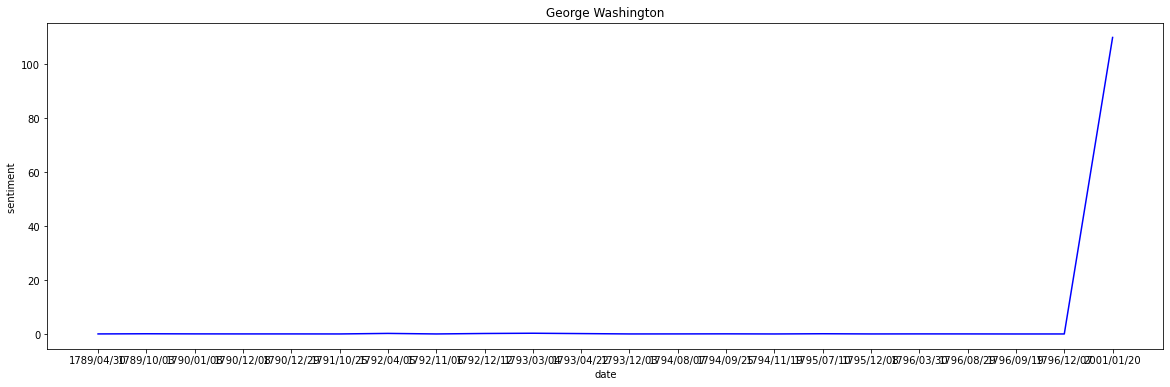

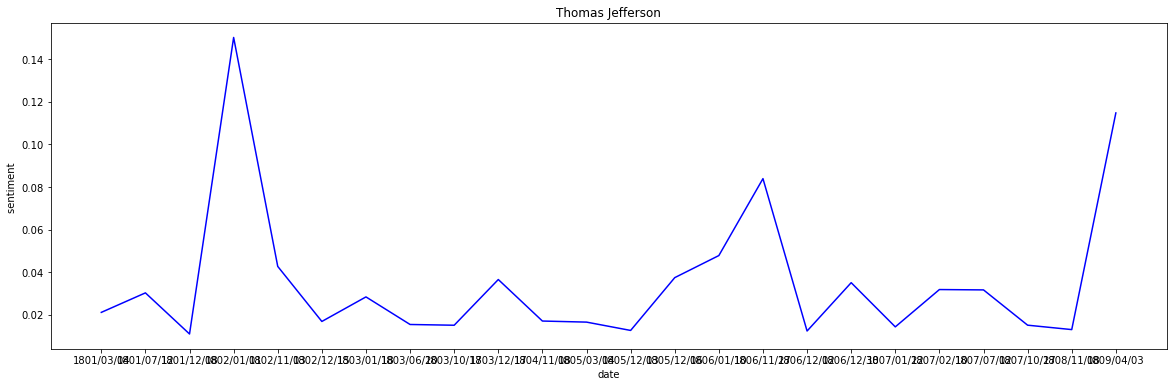

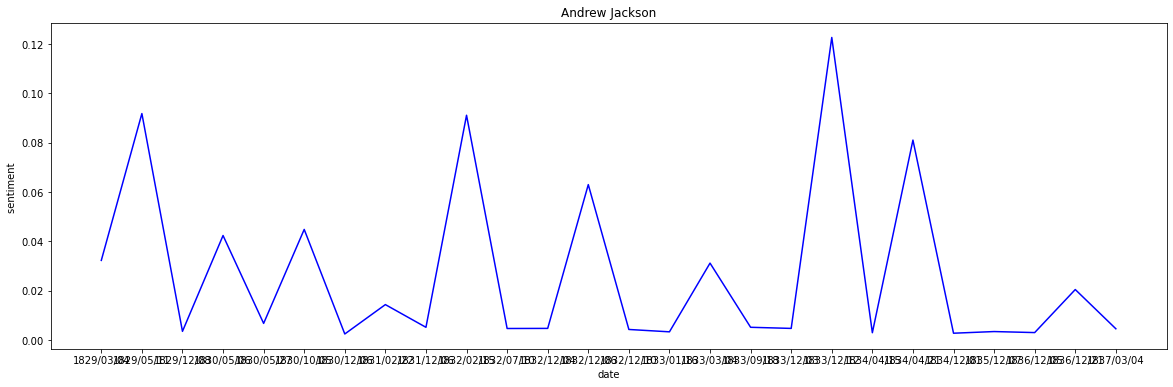

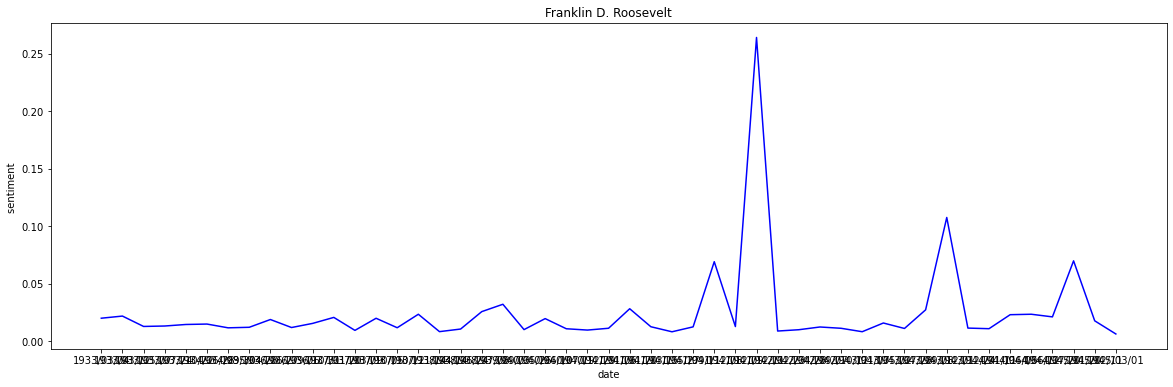

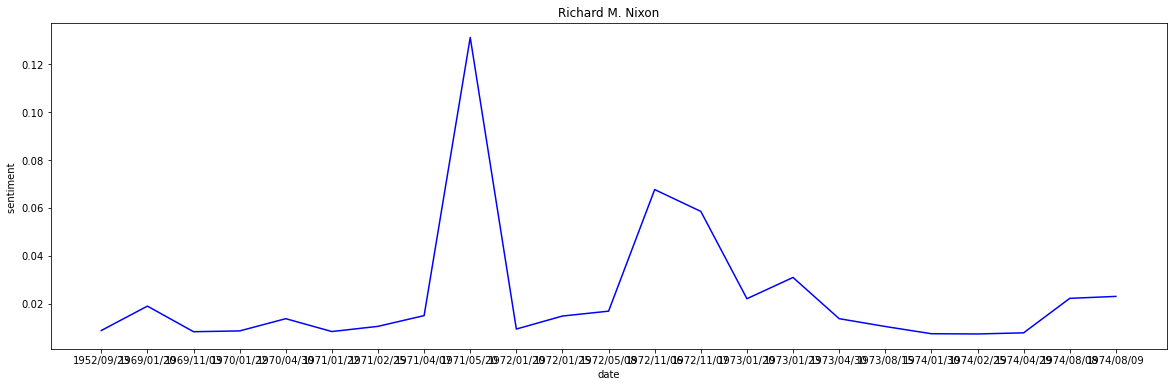

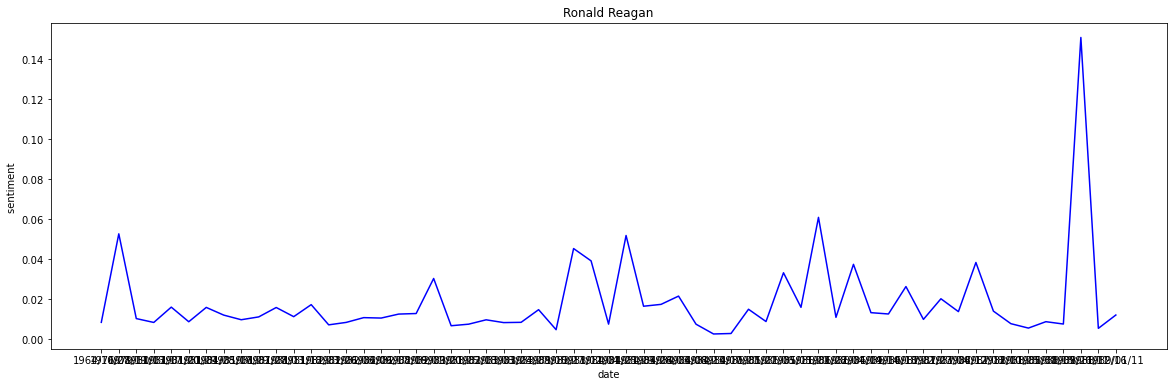

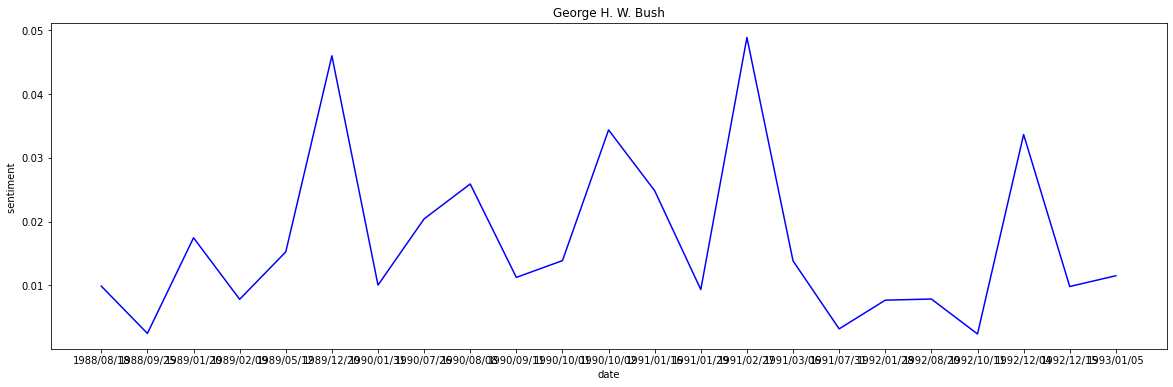

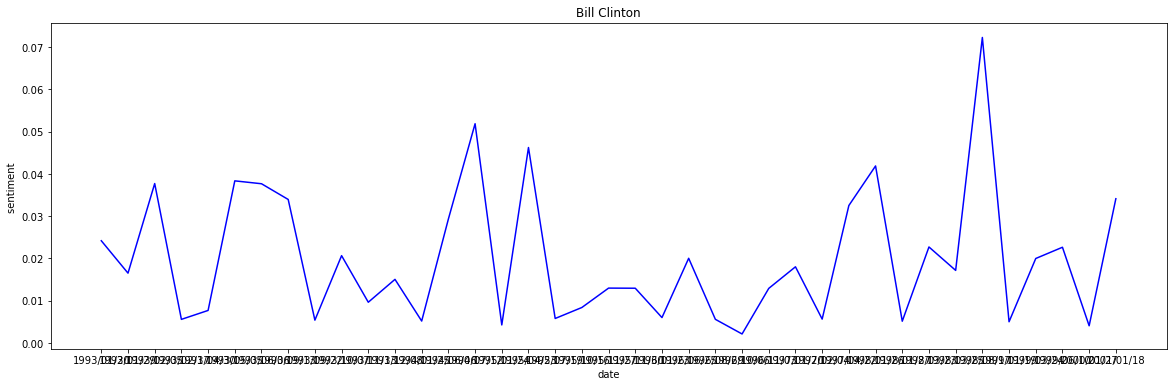

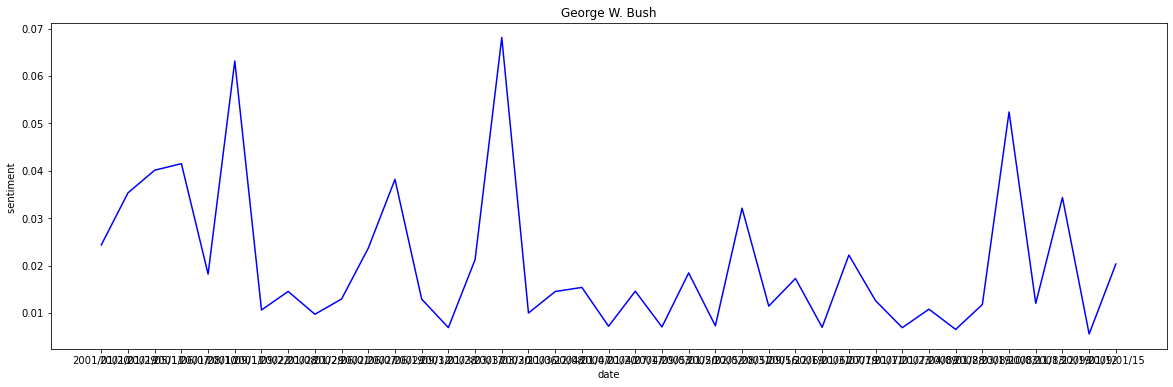

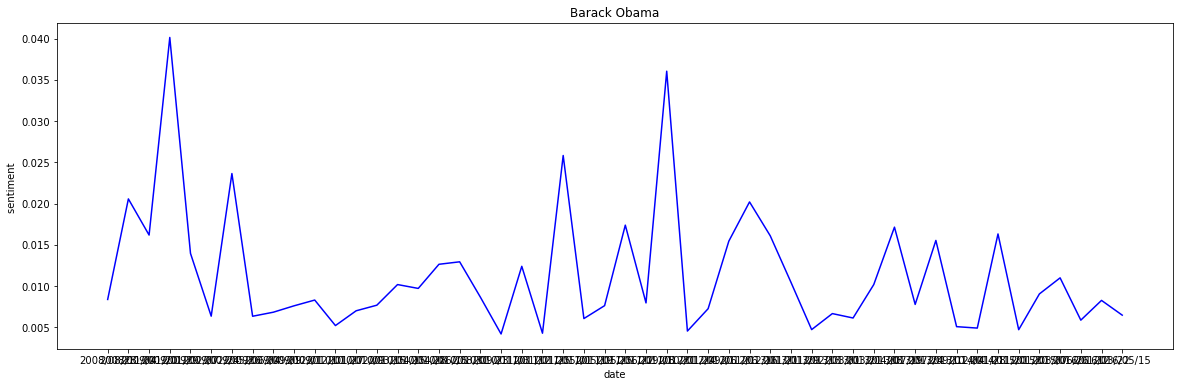

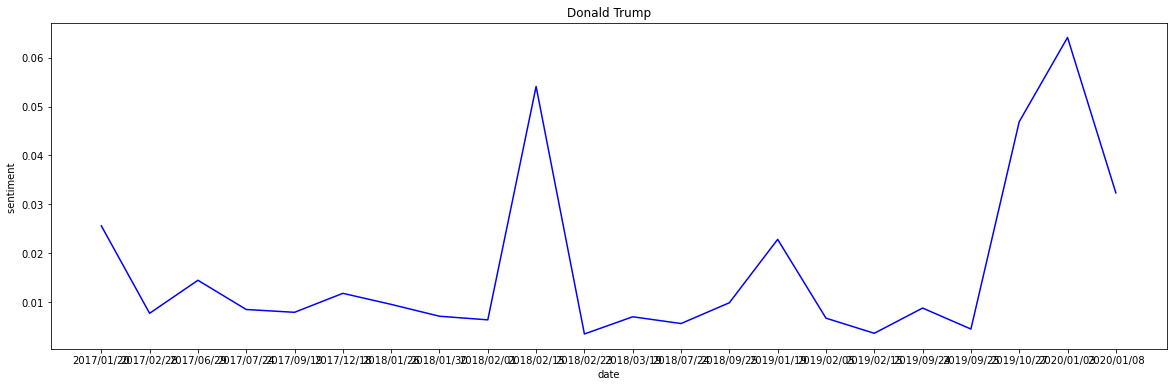

In [60]:
import matplotlib.pyplot as plt

for president in list_president:
    sentiment_p=[]
    #sentiment_n=[]
    date =[]
    for i in data.index: 
        if president == data ['president name'][i]: 
            sentiment_p.append(data['scores P'][i])
            #sentiment_n.append(data['scores N'][i])
            date.append((data['date'][i]))
    plt.figure(figsize = (20,6))
    plt.plot(date, sentiment_p, 'b-')
    #plt.plot(date, sentiment_n, 'r-')
    
    plt.xlabel('date')
    plt.ylabel('sentiment ', )
    plt.title(president)
    plt.show()
    
